## Notebook to Simulate MIRI Observations based on NEMESIS Outputs

When launching the notebook, make sure in the right Anaconda environment. i.e. type

<code> source activate mirisim </code> 

in the terminal before starting the notebook.  This is based on contributions from A. Glasse, N. Rowe-Gurney, and the MIRISim walkthrough.

Mirisim can be run via notebooks or directly as a callable python package. 

Steps:

1. Read in NEMESIS Uranus cubes and interpolate to a single cube.
1. Set up MIRISim simulation and run on all three dispersers (SHORT, MEDIUM, LONG).
1. Inspect outputs with MIRISim_outputs notebook.


L.N. Fletcher (2021)

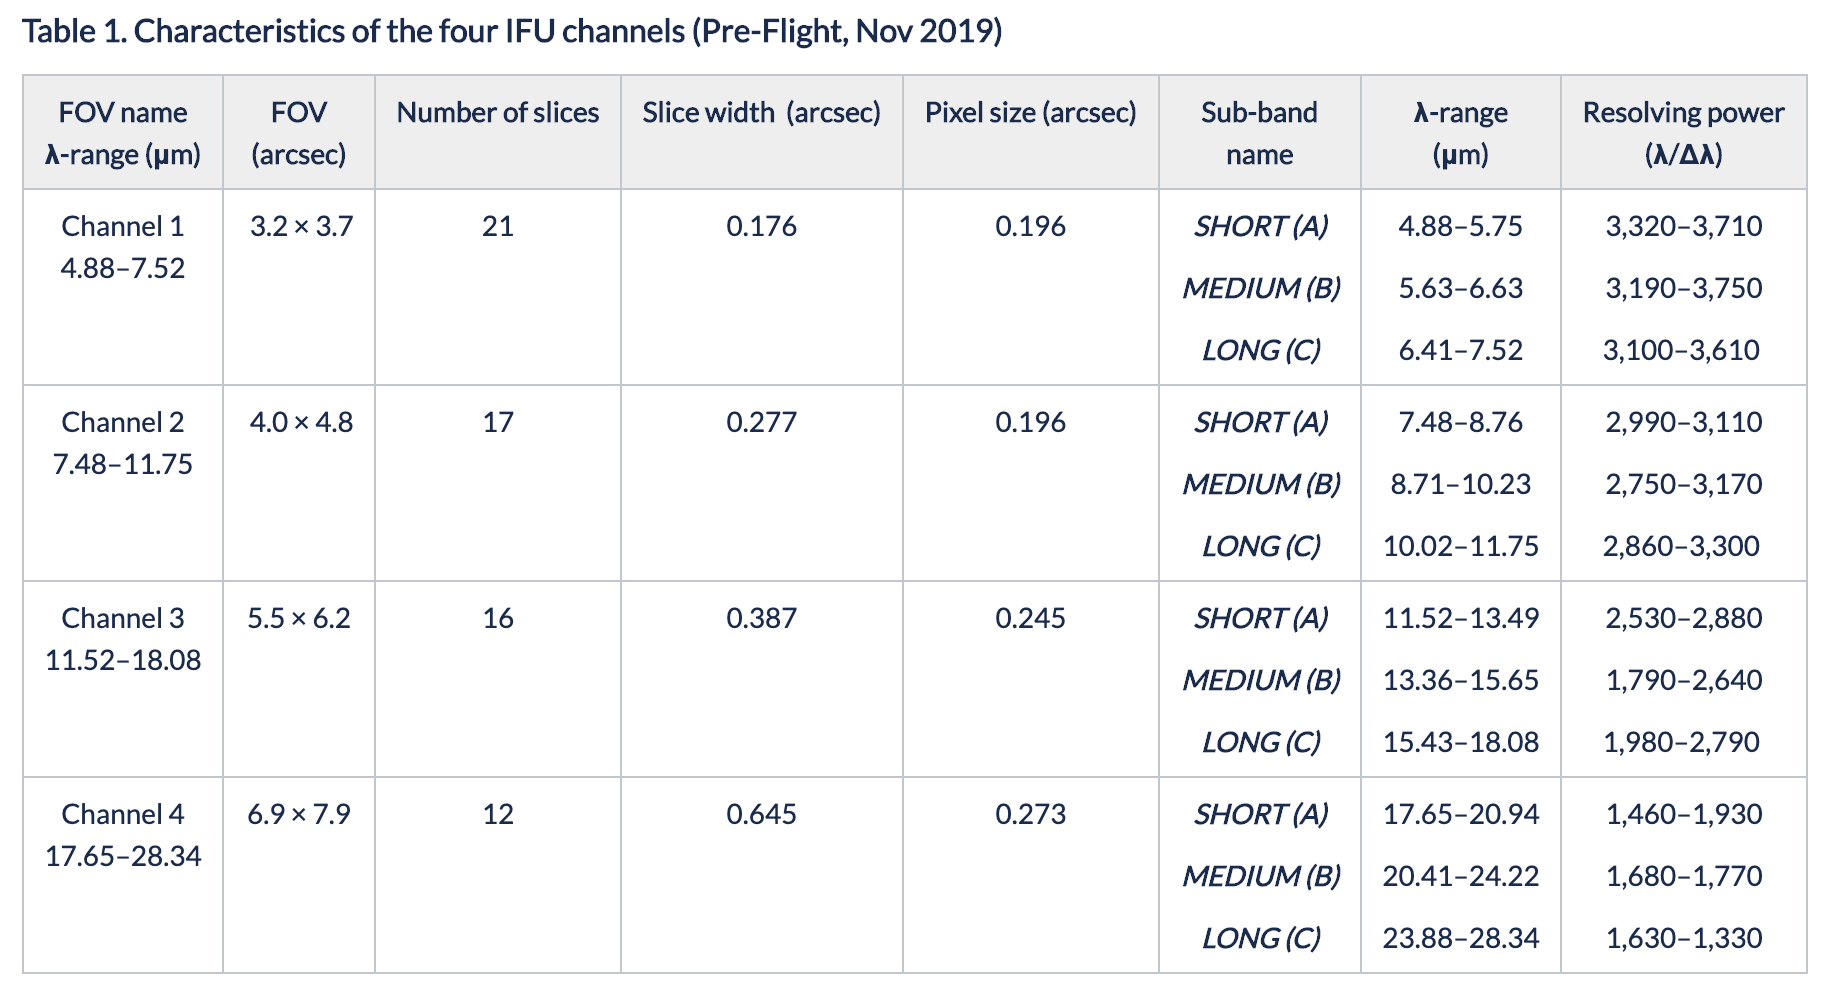

In [1]:
# Set up MIRISIM and import useful tools:
from mirisim import MiriSimulation

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SceneConfig, SimulatorConfig
#from mirisim.skysim import wrap_pysynphot as wS

# import scene component generators
from mirisim.skysim import Background

#other tools to be used
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

import matplotlib.pyplot as plt    # to display images
from matplotlib import colors,cm
%matplotlib inline   

import astropy.units as u


## Converting APT to a MIRI Simulation Configuration
### [This is not actually used]

Following Section 4.4 of the MIRISim user manual, I can use the APT parser to determine what inputs I need for the MIRIsim configuration files.  As my APT contains multiple Uranus MIRI exposures, combined with NIRSpec observations, I'm not actually using the outputs produced by the cell below.

In [3]:
import miri.apt_parser
import mirisim.apt
miri.apt_parser.init_log()
from mirisim import config_parser as parser # SimConfig, SimulatorConfig, SceneConfig

# create a scene using the default parameters to simplify the example
scene_config = parser.SceneConfig.from_default()

# read the MIRI observations from the APT file
observations = miri.apt_parser.parse_apt("Uranus_1248_v2020.5.aptx")

# run a MIRISim simulation using the observation specifications from the APT file
#mirisim.apt.run(observations, scene_config)

simulator_config = parser.SimulatorConfig.from_default()
mirisim.apt.run(observations, scene_config, dryrun=True,simulator=simulator_config)

2021-03-03 13:22:11,863 - INFO - Initializing Background
2021-03-03 13:22:11,927 - INFO - Initializing Point
2021-03-03 13:22:11,927 - INFO - Initializing Point
2021-03-03 13:22:11,957 - INFO - Initializing Point
2021-03-03 13:22:11,978 - INFO - Initializing Point
2021-03-03 13:22:11,978 - INFO - Initializing Point
2021-03-03 13:22:12,027 - INFO - Initializing FlatDisk
2021-03-03 13:22:12,028 - INFO - Initializing Losvd
2021-03-03 13:22:12,029 - INFO - Initializing Galaxy
2021-03-03 13:22:12,029 - INFO - Initializing Galaxy
2021-03-03 13:22:12,030 - INFO - Initializing Galaxy


13:22:12 INFO     Uranus_1248_v2020.5.aptx: Observation {http://www.stsci.edu/JWST/APT/Template/NirspecIFUSpectroscopy}NirspecIFUSpectroscopy
13:22:12 INFO     Uranus_1248_v2020.5.aptx: Observation {http://www.stsci.edu/JWST/APT/Template/NirspecIFUSpectroscopy}NirspecIFUSpectroscopy
13:22:12 INFO     Uranus_1248_v2020.5.aptx: Observation {http://www.stsci.edu/JWST/APT/Template/NirspecIFUSpectroscopy}NirspecIFUSpectroscopy
13:22:12 INFO     Uranus_1248_v2020.5.aptx: Observation {http://www.stsci.edu/JWST/APT/Template/NirspecIFUSpectroscopy}NirspecIFUSpectroscopy


2021-03-03 13:22:12,055 - INFO - Initializing Background


13:22:12 INFO     obs1_IMA_F770W completed in 00h00m00s
13:22:12 INFO     obs1_MRS_SHORT completed in 00h00m00s
13:22:12 INFO     obs1_IMA_F770W already exists, skipping.
13:22:12 INFO     obs1_MRS_MEDIUM completed in 00h00m00s
13:22:12 INFO     obs1_IMA_F770W already exists, skipping.
13:22:12 INFO     obs1_MRS_LONG completed in 00h00m00s
13:22:12 INFO     obs3_IMA_F560W completed in 00h00m00s
13:22:12 INFO     obs3_MRS_SHORT completed in 00h00m00s
13:22:12 INFO     obs3_IMA_F560W already exists, skipping.
13:22:12 INFO     obs3_MRS_MEDIUM completed in 00h00m00s 
13:22:12 INFO     obs3_IMA_F560W already exists, skipping.
13:22:12 INFO     obs3_MRS_LONG completed in 00h00m00s 
13:22:12 INFO     obs5_IMA_F1000W completed in 00h00m00s 
13:22:12 INFO     obs5_MRS_SHORT completed in 00h00m00s 
13:22:12 INFO     obs5_IMA_F1000W already exists, skipping.
13:22:12 INFO     obs5_MRS_MEDIUM completed in 00h00m00s 
13:22:12 INFO     obs5_IMA_F1000W already exists, skipping.
13:22:12 INFO     obs

## 1. Interpolating NEMESIS Spectral Cubes

Each disperser/channel sub-band has a unique wavelength range and resolving power following Fig. 14 of Wells+2015, so my 12 cubes each have different dispersion and wavelength coverage (sometimes overlapping between sub-bands).

#### Mapping Simulation Cube to MRS Parameters

* Detector = Specify Dectector (SW = channels 1,2, LW= channels 3,4)
* Channel = channels 1-4 (also called MRS subbands)
* Disperser = Specify disperser to use (SHORT/MEDIUM/LONG, aka A/B/C)

1. SW 1 SHORT/A 
1. SW 1 MEDIUM/B
1. SW 1 LONG/C
1. SW 2 SHORT/A
1. SW 2 MEDIUM/B
1. SW 2 LONG/C
1. LW 3 SHORT/A
1. LW 3 MEDIUM/B
1. LW 3 LONG/C
1. LW 4 SHORT/A
1. LW 4 MEDIUM/B
1. LW 4 LONG/C

We need to combine these into three disperser settings (both short and long detectors at the same time) and then run the pipeline three times (SHORT, MEDIUM, LONG).  

As the dispersion is different for all 12 cubes, we have two options:

1. Run 12 seperate MIRISim calculations, but acknowledging that half of the MIRI detector images will be garbage.
1. Combine all 12 cubes, interpolated to the finest spectral resolution.

The following cells first test the interpolation scheme, and then loop over all points in the array to generate a new combined FITS file.

## 1A:  Testing the interpolation scheme for a single pixel

3268
(1313, 61, 61)
Wavelengths: 1 4.86 5.81971 1313 0.0007309288989471645
(1251, 61, 61)
Wavelengths: 2 5.61 6.70914 1251 0.0008786088652271543
(1207, 61, 61)
Wavelengths: 3 6.48 7.73965 1207 0.0010436203426433775
(1168, 61, 61)
Wavelengths: 4 7.43 8.879 1168 0.001240582090534576
(1070, 61, 61)
Wavelengths: 5 8.59 10.2596 1070 0.0015603733954028549
(1114, 61, 61)
Wavelengths: 6 9.91 11.8383 1114 0.001730969393060708
(974, 61, 61)
Wavelengths: 7 11.44 13.6398 974 0.002258522065023622
(689, 61, 61)
Wavelengths: 8 13.22 15.7564 689 0.0036812769830313406
(760, 61, 61)
Wavelengths: 9 15.27 18.1968 760 0.003851052334434108
(606, 61, 61)
Wavelengths: 10 17.53 21.1546 606 0.005981187222420973
(697, 61, 61)
Wavelengths: 11 20.43 24.6544 697 0.006060831515997691
(674, 61, 61)
Wavelengths: 12 23.82 28.7435 674 0.007304896232989846
(11523,) (11523,)
(23870,) (23870,)


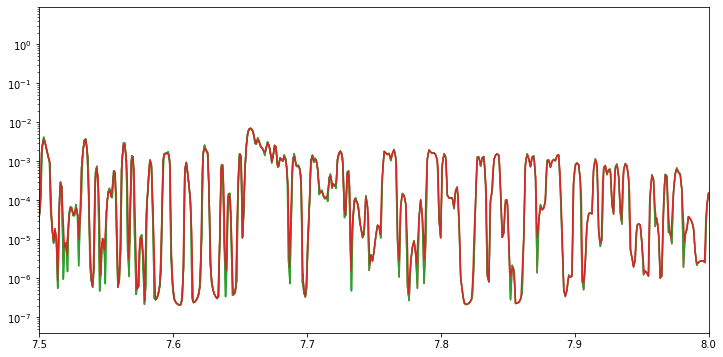

In [45]:
wmin=4.87
wmax=28.74
dw=0.001
nx=61
ny=61


npts=int(np.ceil((wmax-wmin)/dwave))
print(npts)


ix=30
iy=30

fig, ax = plt.subplots(figsize=(12,6))
    
for ichan in range(1,13): 
    
#ichan=8

    if ichan==1:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan1_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan1_wave.fits"
    if ichan==2:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan2_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan2_wave.fits"
    if ichan==3:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan3_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan3_wave.fits"
    if ichan==4:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan4_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan4_wave.fits"
    if ichan==5:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan5_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan5_wave.fits"
    if ichan==6:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan6_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan6_wave.fits"
    if ichan==7:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan7_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan7_wave.fits"
    if ichan==8:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan8_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan8_wave.fits"
    if ichan==9:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan9_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan9_wave.fits"
    if ichan==10:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan10_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan10_wave.fits"
    if ichan==11:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan11_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan11_wave.fits"
    if ichan==12:
        u_raw_fits = "NEMESISCubes/uranusMRS_chan12_radJy.fits"
        wav_fits = "NEMESISCubes/uranusMRS_chan12_wave.fits"

    hdu_list = fits.open(u_raw_fits)
    hdu = hdu_list[0]
    data=hdu.data
    print(data.shape)
    
    
    

    whdu_list = fits.open(wav_fits)
    whdu = whdu_list[0]

    wavegrid=whdu.data
    wavegrid=wavegrid.flatten()
    radiance=data[:,ix,iy]
    
    if ichan==1:
        waveout=wavegrid
        radout=radiance
    
    if ichan>=2:
        waveout=np.concatenate((waveout,wavegrid))
        radout=np.concatenate((radout,radiance))
    
    ax.plot(wavegrid,data[:,ix,iy])
    ax.set_yscale('log')


    vmin=np.min(wavegrid)
    vmax=np.max(wavegrid)
    nwav=len(wavegrid)
    dwave=(vmax-vmin)/nwav

    print("Wavelengths:",ichan,vmin,vmax,nwav,dwave)
    
    
print(waveout.shape,radout.shape)

s = np.argsort(waveout)
waveout=waveout[s]
radout=radout[s]

from scipy import interpolate
f = interpolate.interp1d(waveout,radout)
wavnew=np.arange(wmin, wmax, dw)
radnew=f(wavnew)
ax.plot(waveout,radout)
ax.plot(wavnew,radnew)
ax.set_xlim(7.5,8) 

print(wavnew.shape,radnew.shape)





## 1B.  Intepolating to produce a single NEMESIS FITS file.

Note:  Should only have to do this once.

In [47]:
wmin=4.87
wmax=28.74
dwave=0.001 # Selected to provide a round number for the MIRI dispersion.
nx=61
ny=61


npts=int(np.ceil((wmax-wmin)/dwave))
print(npts)

outcube=np.empty(shape=(npts,nx,ny))

for ix in range(nx):
    for iy in range(ny):
        for ichan in range(1,13): 
    
            if ichan==1:
                ConfigPath = 'MRS_1SHORT'
                disperser = 'SHORT'
                detector = 'SW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan1_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan1_wave.fits"
            if ichan==2:
                ConfigPath = 'MRS_1MEDIUM'
                disperser = 'MEDIUM'
                detector = 'SW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan2_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan2_wave.fits"
            if ichan==3:
                ConfigPath = 'MRS_1LONG'
                disperser = 'LONG'
                detector = 'SW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan3_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan3_wave.fits"
            if ichan==4:
                ConfigPath = 'MRS_2SHORT'
                disperser = 'SHORT'
                detector = 'SW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan4_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan4_wave.fits"
            if ichan==5:
                ConfigPath = 'MRS_2MEDIUM'
                disperser = 'MEDIUM'
                detector = 'SW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan5_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan5_wave.fits"
            if ichan==6:
                ConfigPath = 'MRS_2LONG'
                disperser = 'LONG'
                detector = 'SW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan6_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan6_wave.fits"
            if ichan==7:
                ConfigPath = 'MRS_3SHORT'
                disperser = 'SHORT'
                detector = 'LW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan7_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan7_wave.fits"
            if ichan==8:
                ConfigPath = 'MRS_3MEDIUM'
                disperser = 'MEDIUM'
                detector = 'LW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan8_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan8_wave.fits"
            if ichan==9:
                ConfigPath = 'MRS_3LONG'
                disperser = 'LONG'
                detector = 'LW'    
                u_raw_fits = "NEMESISCubes/uranusMRS_chan9_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan9_wave.fits"
            if ichan==10:
                ConfigPath = 'MRS_4SHORT'
                disperser = 'SHORT'
                detector = 'LW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan10_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan10_wave.fits"
            if ichan==11:
                ConfigPath = 'MRS_4MEDIUM'
                disperser = 'MEDIUM'
                detector = 'LW'
                u_raw_fits = "NEMESISCubes/uranusMRS_chan11_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan11_wave.fits"
            if ichan==12:
                ConfigPath = 'MRS_4LONG'
                disperser = 'LONG'
                detector = 'LW'    
                u_raw_fits = "NEMESISCubes/uranusMRS_chan12_radJy.fits"
                wav_fits = "NEMESISCubes/uranusMRS_chan12_wave.fits"

            hdu_list = fits.open(u_raw_fits)
            hdu = hdu_list[0]
            data=hdu.data
#            print(data.shape)
            whdu_list = fits.open(wav_fits)
            whdu = whdu_list[0]

            wavegrid=whdu.data
            wavegrid=wavegrid.flatten()
            radiance=data[:,ix,iy]

            if ichan==1:
                waveout=wavegrid
                radout=radiance

            if ichan>=2:
                waveout=np.concatenate((waveout,wavegrid))
                radout=np.concatenate((radout,radiance))

       # print(waveout.shape,radout.shape)

        s = np.argsort(waveout)
        waveout=waveout[s]
        radout=radout[s]

        from scipy import interpolate
        f = interpolate.interp1d(waveout,radout)
        vmin=4.87
        dwave=0.001
        wavnew=np.arange(vmin, 28.74, dwave)
        radnew=f(wavnew)
        #ax.plot(waveout,radout)
        #ax.plot(wavnew,radnew)
        #ax.set_xlim(7.5,8) 

        #print(wavnew.shape,radnew.shape)
        outcube[:,ix,iy]=radnew

        print(ix,iy,np.max(radnew))

   # print("Dispersion:",dwave)

crpix = (1, 1, 1)
crval = (0., 0., wmin)
dpix = 0.11                 # Pixel size in arcsec
dwave = dw             # micron (bw / 1300 ~
cdelt = (dpix, dpix, dwave)

hdu.header['CRVAL1'] = crval[0]
hdu.header['CRPIX1'] = crpix[0]
hdu.header['CDELT1'] = cdelt[0]
hdu.header['CUNIT1'] = u.arcsec.to_string()
hdu.header['CTYPE1'] = 'RA---TAN'

hdu.header['CRVAL2'] = crval[1]
hdu.header['CRPIX2'] = crpix[1]
hdu.header['CDELT2'] = cdelt[1]
hdu.header['CUNIT2'] = u.arcsec.to_string()
hdu.header['CTYPE2'] = 'DEC--TAN'

hdu.header['CRVAL3'] = crval[2]
hdu.header['CRPIX3'] = crpix[2]
hdu.header['CDELT3'] = cdelt[2]
hdu.header['CUNIT3'] = u.micron.to_string()
hdu.header['CTYPE3'] = 'WAVE    '

hdu.header['UNITS'] = 'uJy / arcsec2'  #u.microjansky.to_string()

hdu.data = np.multiply(outcube, 1.0e6)  # NEMESIS data in Jy/arcsec^2, multiply to get microJy/arcsec^2

run_file_name = 'MIRIuranus_combined.fits'
if os.path.isfile(run_file_name):
    os.remove(run_file_name)
hdu.writeto(run_file_name)

print("Modified FITS file created")


23870
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(115

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (11523,)
(11523,) (

## 2. Run Simulation for SHORT/MEDIUM/LONG

1. Use SimConfig to set up the parameters for the MRS simulation.  These are informed by the APT file.
1. Use SimulatorConfig in its default mode.
1. Use SceneConfig to specify the external scene.ini file (which contains the name of the FITS file).
1. With the scene and the setup of the simulation created, we can run the simulation.


Outputs to unique directory format: YYYYMMDD_HHMMSS_mirisim


Notes:
* Note that for internal consistency in MIRISim, all settings (including those not used in the MRS simulation here) must be set. Those not being used in this simulation are labelled with <code> NOT USED HERE </code> in the comments of each line.
* A background is added automatically by MIRISim.  We only need to use the <code> Background </code> if we want to add a different background to the scene in the FITS file. 
* Dither is set to False for testing purposes.  For the MRS, MIRISim currently uses the point source dither patterns as described in the APT, and are working on implementing the extended source patterns. The patterns optimised for the different channels are available by chosing a different ‘ditherstart’ argument.
* Ngroups, Nint, Nexp are all from APT file.
* The ConfigPath needs to change for the three dispersers (SHORT/MEDIUM/LONG).  <code> mirisim --generate-configfile</code> generates mrs_simulation_commented.ini.  In that file, you’ll find all of the ConfigPaths in the form MRS_#SHORT where the channel # sets where to center the array.  I choose to use 1SHORT, 1MEDIUM and 1LONG, as Channel 1 always has the smallest FoV should be determining where the FoV is centred.  The other paths will be determined by the offsets between channels (with the larger FoVs) as shown in Wells et al. (2015) Fig. 12. 
* The imager filter isn't used when using MRS.

In [126]:
disperser='LONG'

detector='BOTH'
if disperser=='SHORT':
    ConfigPath = 'MRS_1SHORT'
if disperser=='MEDIUM':
    ConfigPath = 'MRS_1MEDIUM'    
if disperser=='LONG':
    ConfigPath = 'MRS_1LONG'      
    
ngroups=10
nint=3
nexp=1


### create a low level background for the scene
# bg = Background(level='low', gradient = 5., pa = 15.)  # Gradient=0 == contant background)
# NOTE!  bg is currently unused, MIRISim adds its own standand background.


sim_config = SimConfig.makeSim(
    name = 'UranusMIRI',           # name given to simulation,
    scene = 'uranus_scene',         # name of scene file to input,
    rel_obsdate = 0.0,              # relative observation date (0 = launch, 1 = end of 5 yrs),
    POP = 'MRS',                    # Component on which to center (Imager or MRS),
    ConfigPath = ConfigPath,      # Configure the Optical path (MRS sub-band)
    Dither = False,                 # Dither  - use false for test case
    StartInd = 1,                   # Start index for dither pattern
    NDither = 4,                    # Number of dither positions (12)
    DitherPat = 'mrs_recommended_dither.dat', # dither pattern to use   - If using REULEAUX need to update,
    disperser = disperser,        # Which disperser to use (SHORT/MEDIUM/LONG)
    detector = detector,            # Specify Channel (SW = channels 1,2, LW= channels 3,4)
    mrs_mode = 'FAST',          # MRS read mode (default is SLOW. ~ 24s)
    mrs_exposures = nexp,          # MRS number of exposures
    mrs_integrations = nint,      # MRS number of integrations
    mrs_frames = ngroups,            # MRS number of groups (for MIRI, # Groups = # Frames)
    ima_exposures = 1,          # IMA number of exposures,  ####NOT USED 
    ima_integrations = 10,      # IMA number of integrations (5)", ####NOT USED
    ima_frames = 10,            # IMA number of groups (for MIRI, # Groups = # Frames), ####NOT USED
    ima_mode = 'FAST',          # IMA read mode (default is FAST ~ 2.3 s), ####NOT USED
    filter = 'F770W',           # IMA Filter to use, ####NOT USED
    readDetect = 'FULL'         # Portion of detector to read out,
)

simulator_config = SimulatorConfig.from_default()
scene_config = SceneConfig('uranus_scene.ini')

### Suggestion from Alistair for adding background (doesn't work).
#scene_config = SceneConfig('uranus_scene.ini',background=bg)
# Export the simulation setup to a file.
sim_config.write('MRS_simulation.ini')


print("Simulation configuration complete.")

sim = MiriSimulation(sim_config, scene_config, simulator_config)

print("Running simulation:")
sim.run()

## Finally check the outputs are as expected

outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The output directory is:',outputdir)
print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))


2021-03-03 17:13:31,511 - INFO - Initializing Background
2021-03-03 17:13:31,517 - INFO - Using scene configuration: uranus_scene.ini


MRS_simulation.ini exists, overwrite (y/[n])?y


2021-03-03 17:13:33,532 - INFO - MIRISim version: 2.3.0
2021-03-03 17:13:33,534 - INFO - MIRI Simulation started.
2021-03-03 17:13:33,535 - INFO - Output will be saved to: 20210303_171333_mirisim
2021-03-03 17:13:33,536 - INFO - Storing configs in output directory.
2021-03-03 17:13:33,544 - INFO - Storing dither pattern in output directory.
2021-03-03 17:13:33,547 - WARNING - Environment variable CDP_DIR is not set. Will look up / store CDP files at ./CDP
2021-03-03 17:13:33,550 - INFO - 
2021-03-03 17:13:33,551 - INFO - 	*** Detector hard reset. NOTE: All latency and drift data will be erased.
2021-03-03 17:13:33,703 - INFO - 
2021-03-03 17:13:33,704 - INFO - 	*** Detector hard reset. NOTE: All latency and drift data will be erased.


Simulation configuration complete.
Running simulation:


2021-03-03 17:13:33,765 - INFO - Setting up simulated Observation, with following settings:
2021-03-03 17:13:33,766 - INFO - Configuration Path: MRS_1LONG
2021-03-03 17:13:33,767 - INFO - Primary optical path: MRS
2021-03-03 17:13:33,767 - INFO - MRS detector: BOTH
2021-03-03 17:13:33,769 - INFO - MRS band: LONG
2021-03-03 17:13:33,770 - INFO - MRS detector readout mode: FAST
2021-03-03 17:13:33,771 - INFO - MRS detector # exposures: 1
2021-03-03 17:13:33,771 - INFO - MRS detector # integrations: 3
2021-03-03 17:13:33,772 - INFO - MRS detector # frames: 10
2021-03-03 17:13:33,774 - INFO - Parsing: input fits
2021-03-03 17:13:33,776 - INFO - Initializing Skycube
2021-03-03 17:13:33,777 - INFO - Loading external scene from FITS MIRIuranus_combined.fits
2021-03-03 17:13:36,708 - INFO - Aligning the centre of the fits file with the centre of the scene
2021-03-03 17:13:36,710 - INFO - Simulating a single pointing.
/opt/anaconda3/envs/mirisim/lib/python3.7/site-packages/gwcs/wcs.py:131: Visi

17:14:59 WARNING  Model is linear in parameters; consider using linear fitting methods.


2021-03-03 17:14:59,624 - INFO - Wrote skycube: 20210303_171333_mirisim/skycubes/skycube_seq1_1LONG.fits
2021-03-03 17:14:59,626 - INFO - Reading 'DISTORTION' model from './CDP/MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_8B.05.01.fits'
2021-03-03 17:14:59,981 - INFO - Reading 'DISTORTION' model from './CDP/MIRI_FM_MIRIFUSHORT_12LONG_DISTORTION_8B.05.01.fits'
2021-03-03 17:15:00,909 - INFO - Downsampling spectral columns of 3721 pixels. This may take long.
2021-03-03 17:16:22,615 - INFO - 3D downsampling took 81.7 seconds
2021-03-03 17:16:22,636 - INFO - Final helper interpolation...
2021-03-03 17:16:22,739 - INFO - All done
2021-03-03 17:16:22,840 - INFO - Reading 'PSF' model from './CDP/MIRI_FM_MIRIFUSHORT_2LONG_PSF_07.02.00.fits'
2021-03-03 17:16:31,258 - INFO - Wrote skycube: 20210303_171333_mirisim/skycubes/skycube_seq1_2LONG.fits
2021-03-03 17:16:31,262 - INFO -  Retrieving CDP file
2021-03-03 17:16:31,264 - INFO -   from sftp 'www.miricle.org/.../MIRI_FM_MIRIFULONG_34LONG_DISTORTION_8B

2021-03-03 17:33:01,745 - INFO -   from sftp 'www.miricle.org/.../MIRI_FM_MIRIFULONG_34LONG_FRINGE_07.02.00.fits'
2021-03-03 17:33:01,745 - INFO -   to cache './CDP/MIRI_FM_MIRIFULONG_34LONG_FRINGE_07.02.00.fits' ...
2021-03-03 17:33:05,814 - INFO - Reading 'FRINGE' model from './CDP/MIRI_FM_MIRIFULONG_34LONG_FRINGE_07.02.00.fits'
2021-03-03 17:33:05,929 - INFO -  Retrieving CDP file
2021-03-03 17:33:05,930 - INFO -   from sftp 'www.miricle.org/.../MIRI_FM_MIRIFULONG_34LONG_PHOTOM_8B.04.00.fits'
2021-03-03 17:33:05,932 - INFO -   to cache './CDP/MIRI_FM_MIRIFULONG_34LONG_PHOTOM_8B.04.00.fits' ...
2021-03-03 17:33:12,256 - INFO - Reading 'PHOTOM' model from './CDP/MIRI_FM_MIRIFULONG_34LONG_PHOTOM_8B.04.00.fits'
2021-03-03 17:33:12,373 - INFO - Reading 'GAIN' model from './CDP/MIRI_FM_MIRIFULONG_34_GAIN_04.00.00.fits'
2021-03-03 17:33:12,406 - INFO - Simulating Detector Mapping for channel ['4'] and band LONG
2021-03-03 17:33:12,407 - INFO - Getting Coefficients and Substitute values
202

2021-03-03 17:40:34,272 - INFO -  Retrieving CDP file
2021-03-03 17:40:34,403 - INFO -   from sftp 'www.miricle.org/.../MIRI_FM_MIRIFULONG_34LONG_FLAT_8B.01.02.fits'
2021-03-03 17:40:34,405 - INFO -   to cache './CDP/MIRI_FM_MIRIFULONG_34LONG_FLAT_8B.01.02.fits' ...
2021-03-03 17:40:37,576 - INFO - Reading 'PIXELFLAT' model from './CDP/MIRI_FM_MIRIFULONG_34LONG_FLAT_8B.01.02.fits'
2021-03-03 17:40:37,671 - WARNING - Could not find exact match for pixel flat-field for detector MIRIFULONG with FAST mode with band='LONG'. An alternative is being used.
2021-03-03 17:40:37,687 - INFO -  Retrieving CDP file
2021-03-03 17:40:37,688 - INFO -   from sftp 'www.miricle.org/.../MIRI_FM_MIRIFULONG_34LONG_LINEARITY_06.02.00.fits'
2021-03-03 17:40:37,688 - INFO -   to cache './CDP/MIRI_FM_MIRIFULONG_34LONG_LINEARITY_06.02.00.fits' ...
2021-03-03 17:40:44,055 - INFO - Reading 'LINEARITY' model from './CDP/MIRI_FM_MIRIFULONG_34LONG_LINEARITY_06.02.00.fits'
2021-03-03 17:40:44,283 - INFO - Reading 'READ

The output directory is: 20210303_171333_mirisim
The subdirectories in the outputdirectory are:
['det_images', 'skycubes', 'illum_models']
The files in the outputdirectory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']
